# Import Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import re 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report ,roc_curve,auc

2025-10-10 12:25:17.985577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760099118.012604    1491 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760099118.020601    1491 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Dataset path

In [2]:
for dirname,_,filenames in os.walk('/kaggle/input'):
    for file in filenames:
        print( os.path.join(dirname,file))

/kaggle/input/sms-spam-collection-dataset/spam.csv


## Load Dataset

In [3]:
path='/kaggle/input/sms-spam-collection-dataset/spam.csv'
df=pd.read_csv(path,encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Data Preprocessing

In [4]:
df=df[['v1','v2']]  # Delete Unnecessary columns
df.columns=['label','sms']
df['label']=df['label'].map({
    'ham':0,
    'spam':1
})
print('Now Dataset looks like: ')
df.head()

Now Dataset looks like: 


,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Define function for sms cleaning

def clean_sms(text):
    text=text.lower()  # convert into lowercase
    text=re.sub(r'[^a-z0-9\s]','',text)  # delete punctuation and special characters
    return text

df['sms']=df['sms'].apply(clean_sms)


In [6]:
df['sms']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                   will  b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: sms, Length: 5572, dtype: object

## Tokenization & Sequencing

In [7]:
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['sms'])


In [8]:
seq=tokenizer.texts_to_sequences(df['sms'])

In [9]:
pad_seq=pad_sequences(seq,maxlen=150)

## Train Test Split data

In [10]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,df['label'],test_size=0.2,random_state=42)

# Building Model


In [23]:
model=Sequential([
    Embedding(input_dim=10000,output_dim=128,input_length=150),
    LSTM(units=128),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
es=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True) # Prevent Overfitting

In [26]:
h=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=15,
    callbacks=[es],
    verbose=1
)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.8795 - loss: 0.3191 - val_accuracy: 0.9731 - val_loss: 0.0751
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.9882 - loss: 0.0508 - val_accuracy: 0.9809 - val_loss: 0.0581
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9963 - loss: 0.0185 - val_accuracy: 0.9776 - val_loss: 0.0663
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9992 - loss: 0.0061 - val_accuracy: 0.9843 - val_loss: 0.0685
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9821 - val_loss: 0.0906


# Model Evaluation

In [27]:
loss,acc=model.evaluate(x_test,y_test)
print('Accuracy Score: ',acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9869 - loss: 0.0586
Accuracy Score:  0.9829596281051636


In [28]:
y_pred=(model.predict(x_test)>0.5).astype(int)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


Text(0.5, 1.0, 'Confusion Matrix')

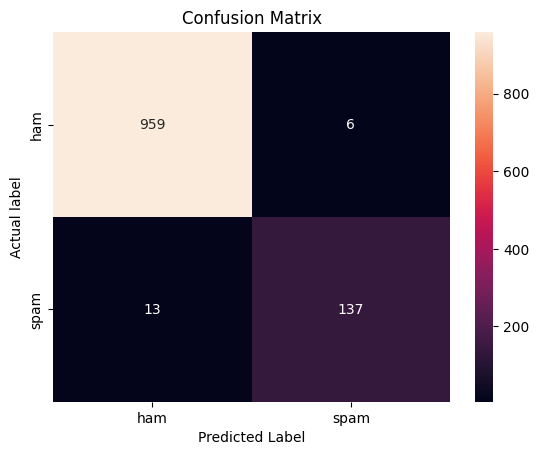

In [31]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['ham','spam'],yticklabels=['ham','spam'])
plt.xlabel("Predicted Label")
plt.ylabel('Actual label')
plt.title('Confusion Matrix')

In [32]:
cp=classification_report(y_test,y_pred,target_names=['ham','spam'])
print("Classification Report: \n",cp)

Classification Report: 
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99       965
        spam       0.96      0.91      0.94       150

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [33]:
y_pred_proba=model.predict(x_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [34]:
fpr,tpr,_=roc_curve(y_test,y_pred_proba)
roc_auc=auc(fpr,tpr)

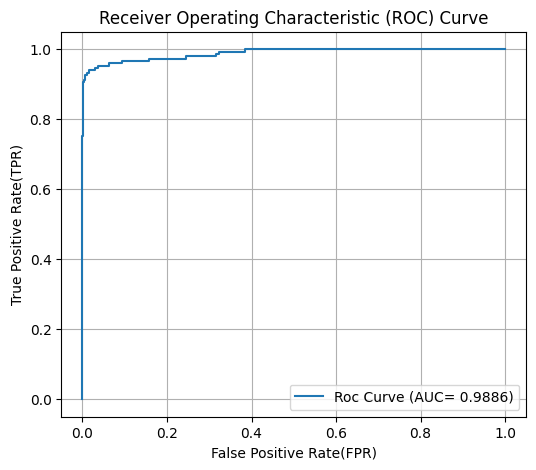

Area under the curve (AUC) score: 0.9886


In [35]:
plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,label=f'Roc Curve (AUC= {roc_auc:.4f})')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f'Area under the curve (AUC) score: {roc_auc:.4f}')

In [36]:
print(f'AUC Score: {auc(fpr,tpr):.2f}')

AUC Score: 0.99
